In [197]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pdb

import sqlite3 
conn = sqlite3.connect('database.sqlite')
cur = conn.cursor()

In [198]:

!pip install python-dotenv

# Explore Data

In [199]:
cur.execute('''SELECT * FROM matches;''')
df = pd.DataFrame(cur.fetchall())
df.columns = [x[0] for x in cur.description]
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


# Teams and games tables

In [200]:
cur.execute('''SELECT * FROM teams;''')
df_teams = pd.DataFrame(cur.fetchall())
df_teams.columns = [x[0] for x in cur.description]
df_teams.head()

,Season,TeamName,KaderHome,AvgAgeHome,ForeignPlayersHome,OverallMarketValueHome,AvgMarketValueHome,StadiumCapacity
0,2017,Bayern Munich,27,26,15,597950000,22150000,75000
1,2017,Dortmund,33,25,18,416730000,12630000,81359
2,2017,Leverkusen,31,24,15,222600000,7180000,30210
3,2017,RB Leipzig,30,23,15,180130000,6000000,42959
4,2017,Schalke 04,29,24,17,179550000,6190000,62271


In [201]:
cur.execute('''SELECT * FROM teams_in_matches;''')
df_teams = pd.DataFrame(cur.fetchall())
df_teams.columns = [x[0] for x in cur.description]
df_teams.head()

,Match_ID,Unique_Team_ID
0,1,26
1,1,46
2,2,26
3,2,42
4,3,26


In [202]:
cur.execute('''SELECT * FROM unique_teams;''')
df_unique = pd.DataFrame(cur.fetchall())
df_unique.columns = [x[0] for x in cur.description]
df_unique.head()

,TeamName,Unique_Team_ID
0,Bayern Munich,1
1,Dortmund,2
2,Leverkusen,3
3,RB Leipzig,4
4,Schalke 04,5


# Goals 

In [203]:
cur.execute("""SELECT AwayTeam AS Team, SUM(FTAG) AS AwayGoals
               FROM matches
               WHERE Season = '2011'
               AND NOT Div ='E0'
               GROUP BY AwayTeam;""")
AwayGoals_df = pd.DataFrame(cur.fetchall())
AwayGoals_df.columns = [x[0] for x in cur.description]
AwayGoals_df.head()

,Team,AwayGoals
0,Aachen,15
1,Augsburg,16
2,Bayern Munich,28
3,Bochum,18
4,Braunschweig,16


In [204]:
cur.execute('''SELECT Season, HomeTeam AS Team, SUM(FTHG) AS HomeGoals
               FROM Matches
               Where Season = 2011
               AND NOT Div ='E0'
               GROUP BY HomeTeam
               ;''')
HomeGoals_df = pd.DataFrame(cur.fetchall())
HomeGoals_df.columns = [x[0] for x in cur.description]
HomeGoals_df.head()

,Season,Team,HomeGoals
0,2011,Aachen,15
1,2011,Augsburg,20
2,2011,Bayern Munich,49
3,2011,Bochum,23
4,2011,Braunschweig,21


In [205]:
team_df = (pd.merge(HomeGoals_df, AwayGoals_df, on='Team'))
team_df.head()

,Season,Team,HomeGoals,AwayGoals
0,2011,Aachen,15,15
1,2011,Augsburg,20,16
2,2011,Bayern Munich,49,28
3,2011,Bochum,23,18
4,2011,Braunschweig,21,16


In [206]:
team_df['TotalGoals']= HomeGoals_df.HomeGoals + AwayGoals_df.AwayGoals
team_df.head()

,Season,Team,HomeGoals,AwayGoals,TotalGoals
0,2011,Aachen,15,15,30
1,2011,Augsburg,20,16,36
2,2011,Bayern Munich,49,28,77
3,2011,Bochum,23,18,41
4,2011,Braunschweig,21,16,37


# Total Wins

In [207]:
cur.execute('''SELECT HomeTeam AS Team, COUNT(FTR) AS HomeWins
               FROM Matches
               Where Season = 2011
               AND FTR = 'H'
               AND NOT Div ='E0'
               GROUP BY AwayTeam
               ;''')
HomeWins_df = pd.DataFrame(cur.fetchall())
HomeWins_df.columns = [x[0] for x in cur.description]
HomeWins_df.head()

,Team,HomeWins
0,Ein Frankfurt,8
1,Nurnberg,8
2,Mainz,5
3,Braunschweig,10
4,Duisburg,6


In [208]:
cur.execute('''SELECT Season, AwayTeam AS Team, COUNT(FTR) AS AwayWins
               FROM Matches
               Where Season = 2011
               AND FTR = 'A'
               AND NOT Div ='E0'
               GROUP BY HomeTeam
               ;''')
AwayWins_df = pd.DataFrame(cur.fetchall())
AwayWins_df.columns = [x[0] for x in cur.description]
AwayWins_df.head()

,Season,Team,AwayWins
0,2011,Dresden,7
1,2011,Bayern Munich,4
2,2011,Dortmund,2
3,2011,Dresden,7
4,2011,Dresden,3


In [209]:
team_df['TotalWins']= HomeWins_df['HomeWins'] + AwayWins_df['AwayWins']
team_df.tail()

,Season,Team,HomeGoals,AwayGoals,TotalGoals,TotalWins
31,2011,St Pauli,36,23,59,10.0
32,2011,Stuttgart,36,27,63,11.0
33,2011,Union Berlin,30,25,55,15.0
34,2011,Werder Bremen,31,18,49,14.0
35,2011,Wolfsburg,29,18,47,NaN


# Histogram visualizing the Total Wins and Goals for each Team 

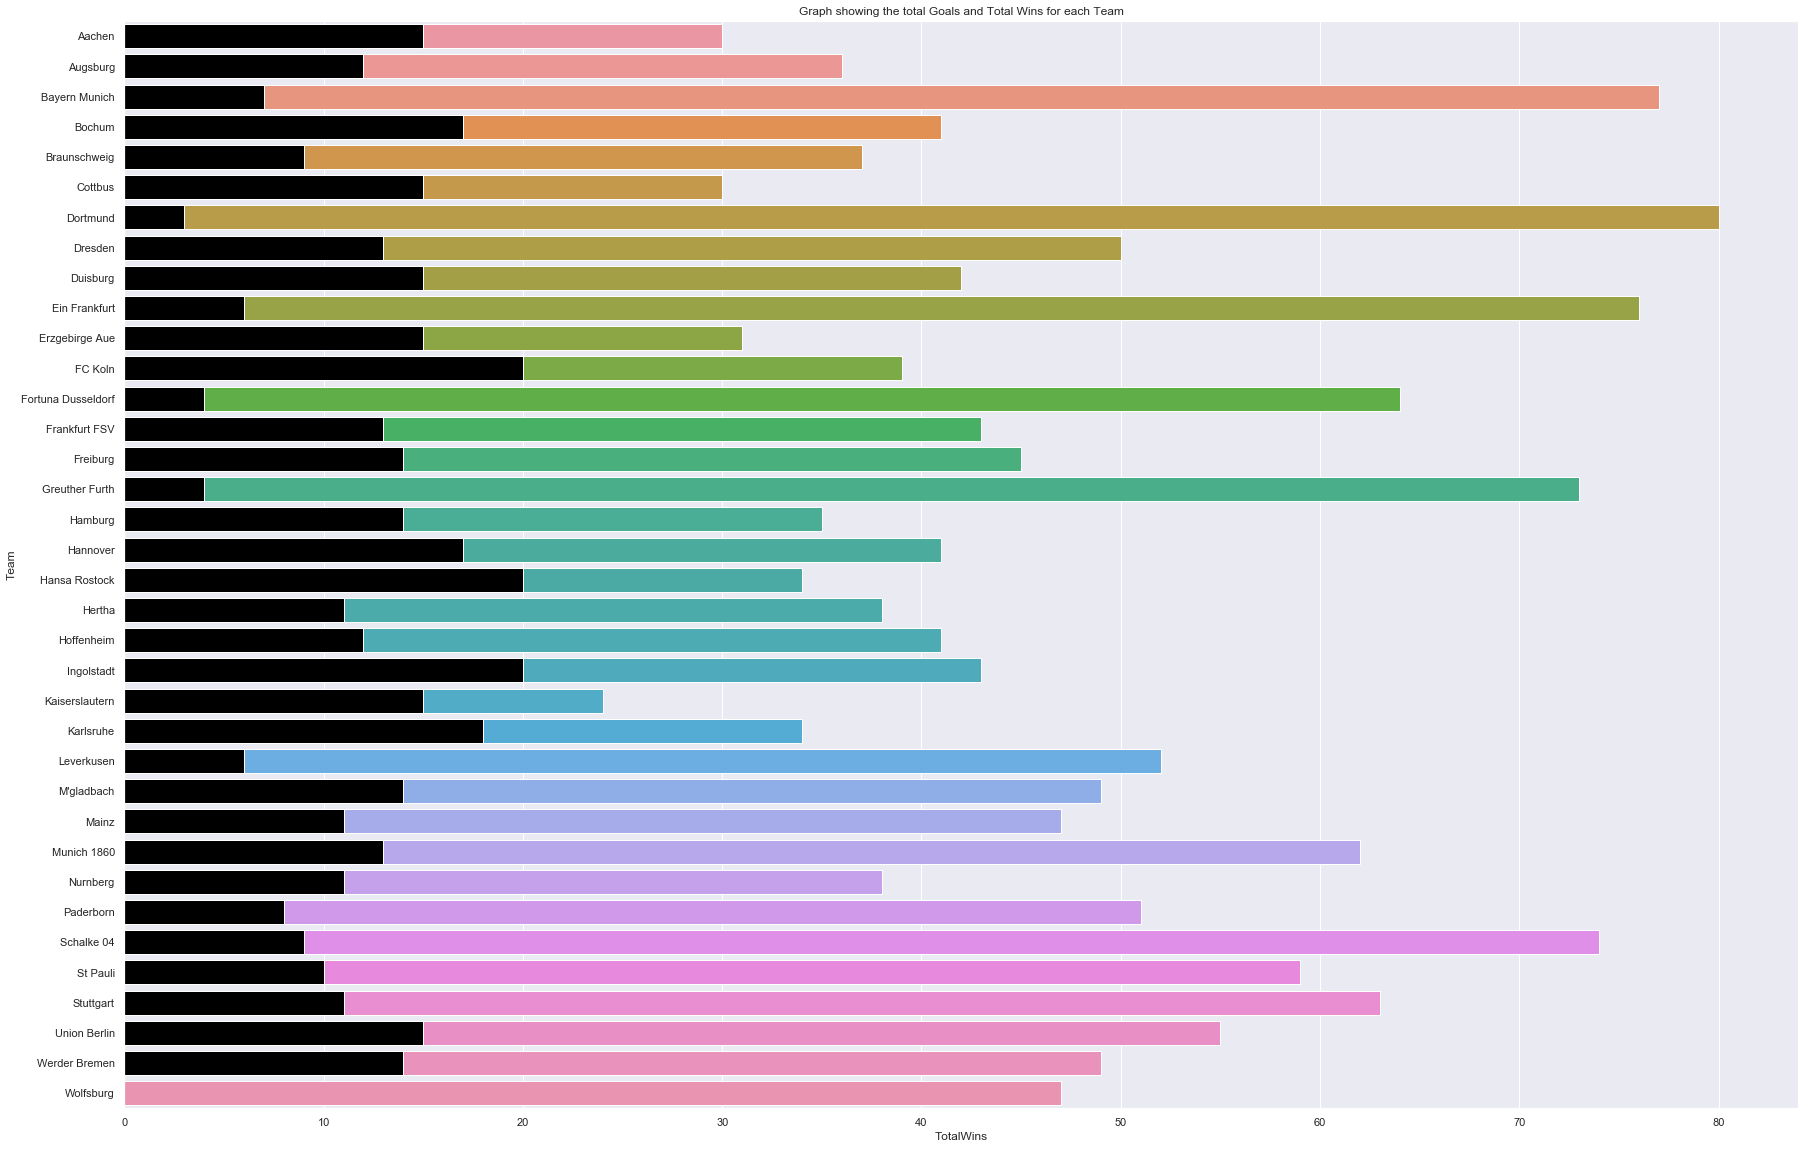

In [210]:
plt.figure(figsize=(30, 20))

ax = sns.barplot(data=team_df,
                  x = 'TotalGoals',
                  y = 'Team').set_title('Graph showing the total Goals and Total Wins for each Team');

ax2 = sns.barplot(data=team_df,
                  x = 'TotalWins',
                  y = 'Team', color='black');

# Total Losses

In [211]:
cur.execute('''SELECT AwayTeam AS Team, COUNT(FTR) AS AwayLosses
               FROM Matches
               Where Season = 2011
               AND FTR = 'H'
               AND NOT Div ='E0'
               GROUP BY AwayTeam
               ;''')
AwayLosses_df = pd.DataFrame(cur.fetchall())
AwayLosses_df.columns = [x[0] for x in cur.description]
AwayLosses_df.head()

,Team,AwayLosses
0,Aachen,8
1,Augsburg,8
2,Bayern Munich,5
3,Bochum,10
4,Braunschweig,6


In [212]:
cur.execute('''SELECT Season, HomeTeam AS Team, COUNT(FTR) AS HomeLosses
               FROM Matches
               Where Season = 2011
               AND FTR = 'A'
               AND NOT Div ='E0'
               GROUP BY HomeTeam
               ;''')
HomeLosses_df = pd.DataFrame(cur.fetchall())
HomeLosses_df.columns = [x[0] for x in cur.description]
HomeLosses_df.head()

,Season,Team,HomeLosses
0,2011,Aachen,7
1,2011,Augsburg,4
2,2011,Bayern Munich,2
3,2011,Bochum,7
4,2011,Braunschweig,3


In [213]:
team_df['TotalLosses']= HomeLosses_df.HomeLosses + AwayLosses_df.AwayLosses
team_df.tail()

,Season,Team,HomeGoals,AwayGoals,TotalGoals,TotalWins,TotalLosses
31,2011,St Pauli,36,23,59,10.0,10.0
32,2011,Stuttgart,36,27,63,11.0,11.0
33,2011,Union Berlin,30,25,55,15.0,15.0
34,2011,Werder Bremen,31,18,49,14.0,14.0
35,2011,Wolfsburg,29,18,47,NaN,NaN


# Histogram visualizing the Total Wins and Goals for each Team 

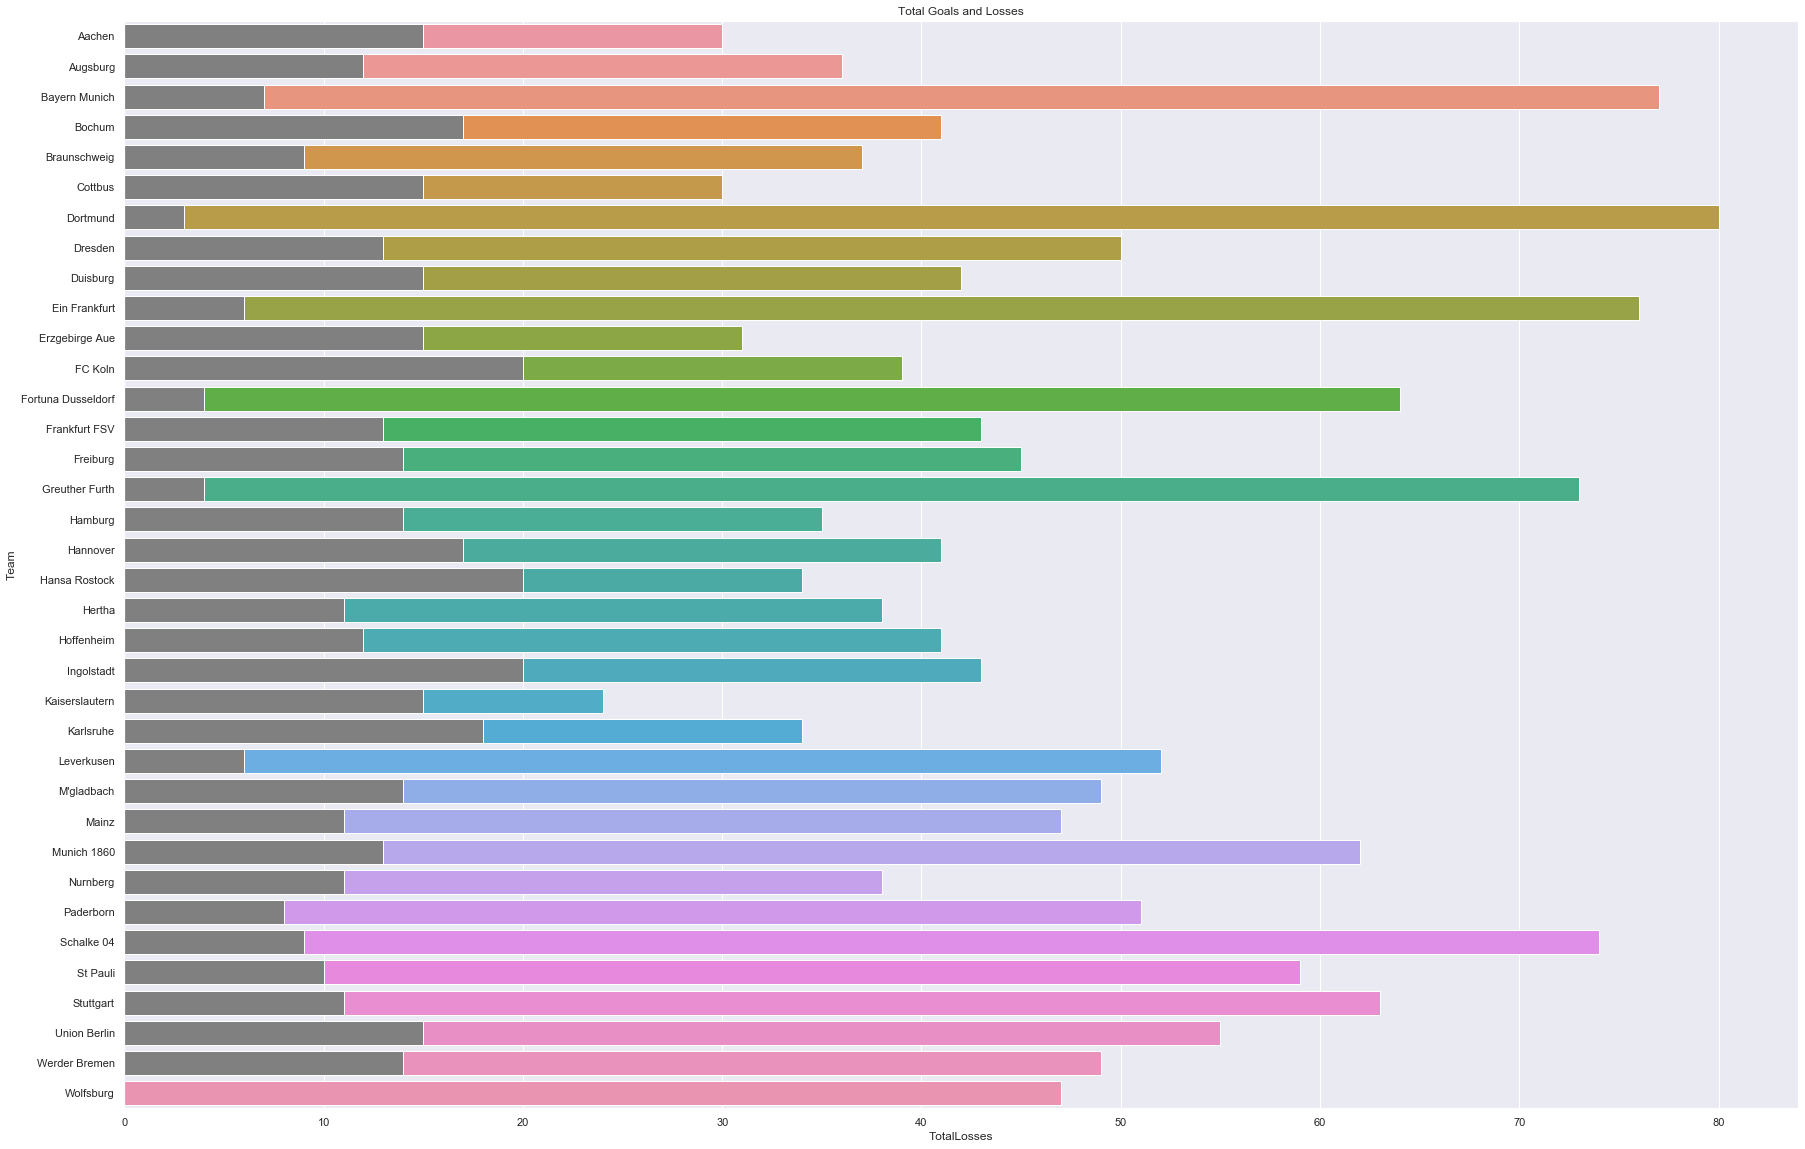

In [214]:
plt.figure(figsize=(30, 20))

ax = sns.barplot(data=team_df,
                  x = 'TotalGoals',
                  y = 'Team').set_title('Total Goals and Losses');

ax2 = sns.barplot(data=team_df,
                  x = 'TotalLosses',
                  y = 'Team', color='grey');

# Incorporating API weather data (2011)

In [237]:
import requests

from datetime import date, datetime
import time
import pymongo
import os


In [238]:
dates_list = []
for date in dates_api_df.Date:
        dates_list.append(date + 'T17:00:00')
dates_list

['2012-03-31T17:00:00',
 '2011-12-11T17:00:00',
 '2011-08-13T17:00:00',
 '2011-11-27T17:00:00',
 '2012-02-18T17:00:00',
 '2012-01-20T17:00:00',
 '2012-02-04T17:00:00',
 '2012-04-21T17:00:00',
 '2011-09-18T17:00:00',
 '2011-10-23T17:00:00',
 '2011-10-01T17:00:00',
 '2012-03-03T17:00:00',
 '2011-08-27T17:00:00',
 '2012-03-17T17:00:00',
 '2011-11-06T17:00:00',
 '2012-05-05T17:00:00',
 '2012-04-11T17:00:00',
 '2011-12-17T17:00:00',
 '2012-02-03T17:00:00',
 '2011-10-29T17:00:00',
 '2012-01-22T17:00:00',
 '2011-12-03T17:00:00',
 '2012-04-14T17:00:00',
 '2012-03-25T17:00:00',
 '2012-03-10T17:00:00',
 '2012-04-07T17:00:00',
 '2011-11-19T17:00:00',
 '2011-10-14T17:00:00',
 '2011-09-24T17:00:00',
 '2012-04-28T17:00:00',
 '2011-12-18T17:00:00',
 '2012-03-02T17:00:00',
 '2012-03-16T17:00:00',
 '2012-02-17T17:00:00',
 '2011-08-06T17:00:00',
 '2011-11-04T17:00:00',
 '2011-09-16T17:00:00',
 '2011-07-15T17:00:00',
 '2012-05-06T17:00:00',
 '2012-02-11T17:00:00',
 '2011-10-02T17:00:00',
 '2012-03-30T17:

In [241]:
import json
import pandas as pd

In [256]:
weather_dic =[]


for date in season11_df['Date']:
    date_format = date + "Z"
    weather = requests.get(f'https://api.darksky.net/forecast/428eda29a9c4c2a0fa189a172ea5a760/52.5200, 13.4050, {date_format}')
    weather_like = weather.json()['currently']
    weather_dic.append(weather_like)

weather_df = pd.DataFrame(weather_dic)
weather_df

,time,summary,icon,precipIntensity,precipProbability,temperature,apparentTemperature,dewPoint,humidity,windSpeed,windGust,windBearing,cloudCover,uvIndex,visibility,precipType
0,1333213200,Partly Cloudy,partly-cloudy-day,0.0,0.0,41.08,33.23,24.82,0.52,14.99,28.77,340,0.44,0.0,6.216,NaN
1,1323622800,NaN,NaN,0.0,0.0,35.20,28.72,28.54,0.76,8.05,8.05,188,NaN,0.0,6.206,NaN
2,1313254800,Clear,clear-day,0.0,0.0,71.62,71.62,50.15,0.47,6.91,8.99,290,0.19,0.0,6.216,NaN
3,1322413200,Windy and Mostly Cloudy,wind,0.0,0.0,48.97,40.81,42.80,0.79,28.77,40.27,240,0.75,0.0,6.216,NaN
4,1329584400,Mostly Cloudy,partly-cloudy-night,0.0,0.0,44.60,38.79,39.22,0.81,11.51,11.51,220,0.75,0.0,6.216,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
160,1335891600,Partly Cloudy,partly-cloudy-day,0.0,0.0,75.19,75.31,61.06,0.62,9.21,9.21,60,0.44,0.0,6.216,NaN
161,1335978000,NaN,NaN,0.0,0.0,75.19,75.19,55.80,0.51,12.01,12.01,45,NaN,NaN,6.206,NaN
162,1336410000,Mostly Cloudy,partly-cloudy-day,0.0,0.0,53.99,53.99,41.91,0.64,3.46,4.00,244,0.68,0.0,6.216,NaN
163,1336496400,Mostly Cloudy,partly-cloudy-day,0.0,0.0,66.21,66.21,43.98,0.45,9.21,9.21,140,0.75,0.0,6.216,NaN


In [253]:
len(dates_api_df)

165

In [257]:
weather_df['icon']

0        partly-cloudy-day
1                      NaN
2                clear-day
3                     wind
4      partly-cloudy-night
              ...         
160      partly-cloudy-day
161                    NaN
162      partly-cloudy-day
163      partly-cloudy-day
164      partly-cloudy-day
Name: icon, Length: 165, dtype: object

In [ ]:
Final_df = df['season', 'date'], 

In [261]:
cur.execute('''SELECT * FROM Matches WHERE Season=2011;''')
season11df_teams = pd.DataFrame(cur.fetchall())
season11df_teams.columns = [x[0] for x in cur.description]
season11df_teams.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1092,D1,2011,2012-03-31,Nurnberg,Bayern Munich,0,1,A
1,1093,D1,2011,2011-12-11,Stuttgart,Bayern Munich,1,2,A
2,1094,D1,2011,2011-08-13,Wolfsburg,Bayern Munich,0,1,A
3,1095,D1,2011,2011-11-27,Mainz,Bayern Munich,3,2,H
4,1096,D1,2011,2012-02-18,Freiburg,Bayern Munich,0,0,D


In [263]:
# raining_dates
raining_dates = []
for timestamp in weather_dates:
    if 'icon' in weather_dates[timestamp] and weather_dates[timestamp]['icon'] == 'rain':
        raining_dates.append(timestamp)
#         raining_dates.append(weather_dates[timestamp]['icon'])
#         raining_dates.append(timestamp, weather_dates[timestamp]['icon'])
#         print(timestamp, weather_dates[timestamp]['icon'])
raining_dates

[]

In [265]:
len(raining_dates)

0

In [266]:
rain = []
for i in raining_dates:
    rain.append(i.split('T')[0])
    
rain

[]

In [268]:
df.head()

,Match_ID,Div,Season,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR
0,1,D2,2009,2010-04-04,Oberhausen,Kaiserslautern,2,1,H
1,2,D2,2009,2009-11-01,Munich 1860,Kaiserslautern,0,1,A
2,3,D2,2009,2009-10-04,Frankfurt FSV,Kaiserslautern,1,1,D
3,4,D2,2009,2010-02-21,Frankfurt FSV,Karlsruhe,2,1,H
4,5,D2,2009,2009-12-06,Ahlen,Karlsruhe,1,3,A


In [269]:
pd.set_option('display.max_columns', None)
raining_df = pd.DataFrame(list(weather_dates.items()), columns=['date', 'weather']) 
raining_df

,date,weather


In [270]:
df.columns

Index(['Match_ID', 'Div', 'Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG',
       'FTAG', 'FTR'],
      dtype='object')

In [271]:
new = pd.DataFrame()
for date in rain:
#     new.append(raining_df.loc[(raining_df["date"] == date), "weather"])
    print(date)
    print(df.loc[df['Date'] == date])

In [272]:
new = pd.DataFrame()
for date in rain:
#     new.append(raining_df.loc[(raining_df["date"] == date), "weather"])
#     print(date)
#     print(df.loc[df['Date'] == date])
      new.append(df.loc[(df['Date'] == date)])
new.head()

""
